In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**1. Import libraries :**

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from time import perf_counter
import seaborn as sns
import random as rn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
import sklearn.metrics as metrics
from IPython.display import Markdown, display
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import GridSearchCV 
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from collections import defaultdict
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras


def printmd(string):
    display(Markdown(string))

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

**2. Load Data :**


In [3]:
# Use Class Labels.xlsx to create the 'class' dataframe containing the classes in the dataframe.
classes = pd.read_excel("ClassLabels.xlsx")
display(classes.head())

,ClassId,Class,ClassAr
0,0,zero,صفر
1,1,one,واحد
2,2,two,اثنان
3,3,three,ثلاثة
4,4,four,اربعة


In [10]:
# Create the 'imagePath' dataframe containing the image paths and classes (used to load the images).
imagePath = pd.DataFrame(columns=['ClassId','ImagePath'])

classeList = list(classes['ClassId'])
pathlist = []
for c in classeList :
    for dirname, _, filenames in os.walk('dataa/'+str(c)):
        for name in filenames:
           imagePath =  imagePath.append({'ClassId': c, 'ImagePath': dirname+'/'+str(name)}, ignore_index=True)
imagePath.head()         

,ClassId,ImagePath
0,0,dataa/0/Image_1667602066.7622786.jpg
1,0,dataa/0/Image_1667581429.554771.jpg
2,0,dataa/0/0 (55).jpg
3,0,dataa/0/Image_1667581426.4690409.jpg
4,0,dataa/0/0 (45).jpg


In [11]:
# convert class id to categorical values useing the dataframe "classes", 
imagePath['Class'] = imagePath['ClassId'].replace(to_replace=imagePath['ClassId'].unique().tolist(),value=classes['Class'].unique().tolist())

In [12]:
imagePath.head()           

,ClassId,ImagePath,Class
0,0,dataa/0/Image_1667602066.7622786.jpg,zero
1,0,dataa/0/Image_1667581429.554771.jpg,zero
2,0,dataa/0/0 (55).jpg,zero
3,0,dataa/0/Image_1667581426.4690409.jpg,zero
4,0,dataa/0/0 (45).jpg,zero


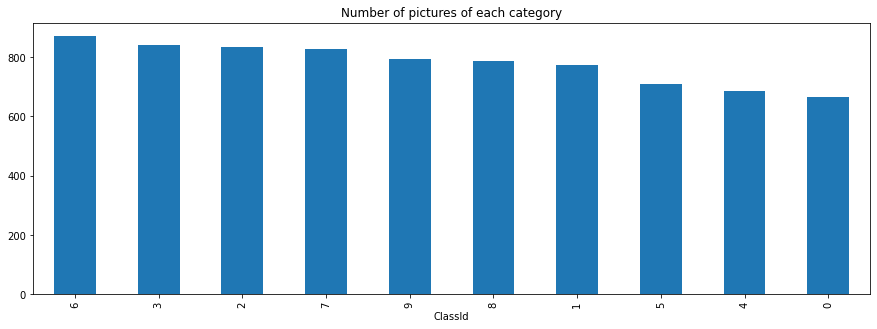

In [13]:
imagePath.groupby("ClassId").size().sort_values(ascending=False).plot.bar(title='Number of pictures of each category',figsize=(15,5))
plt.show()

**3. Define Functions :**


In [14]:
def SplitData(testsize,dataSample):
    df = imagePath.sample(frac = dataSample)

    min = df.groupby("Class").size().min()
    print('{0} Samples per Class'.format(min))
    
    df_TrainingSet = df[0:0].copy()
    df_TestSet = df[0:0].copy()

    for index,row in classes.iterrows():
        
        df_FullSet = df[df['Class'] == row['Class']].sample(min,random_state= 42)
        
        trainingSet, testSet = train_test_split(df_FullSet, test_size= testsize)        
        
        df_TrainingSet = df_TrainingSet.append(trainingSet)
        df_TestSet = df_TestSet.append(testSet)
        
    df_TrainingSet = df_TrainingSet.sample(frac = 1)
    df_TestSet = df_TestSet.sample(frac = 1)    
    
    return df_TrainingSet,df_TestSet

In [15]:
# Load the Images with a generator and Data Augmentation
def create_gen(modelType):
    '''
    Input:
        modelType: the name of the preprocesses a tensor used to preprocesses the images.
    Output:
        train image: the train image after preprocessing.
        val images:the validation image after preprocessing.
        test images:the test image after preprocessing.
    '''
    
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=eval('tf.keras.applications.'+modelType.lower()+'.preprocess_input'),
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=eval('tf.keras.applications.'+modelType.lower()+'.preprocess_input'),
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='ImagePath',  
        y_col='Class',  
        target_size=(300, 300),  
        color_mode='rgb',
        class_mode='categorical',  
        shuffle=True,
        seed=seed_num,
        subset='training',
       
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='ImagePath',
        y_col='Class',
        target_size=(300, 300),
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        seed=seed_num,
        subset='validation',
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='ImagePath',
        y_col='Class',
        target_size=(300, 300),
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False,
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [16]:
def get_model(modelName):
    '''
    Input:
        modelName: the name of the base model.
    Output:
        model: model with all layers freezed in the base model (used to test which model will converge the best with our dataset).  
    '''
       
    base_model  = modelName(weights='imagenet', 
                        input_shape=(300, 300, 3),
                        include_top=False)
    
    base_model.trainable = False

    inputs = keras.Input(shape=(300, 300, 3))

    x = base_model(inputs, training=False)

    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = keras.layers.Dense(10,activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

**4. Choose the best CNN Model architecture  :**

4a. Preparing Data :

In [17]:
#SplitData(0.2,0.1) -> take a 20% random sample from the dataset and split it into 80% training and 10% validation and 10% testing 
train_df, test_df = SplitData(0.2,0.2) 
print('Training {} \t # {} per class'.format(train_df.shape[0], train_df.shape[0] //32))
print('Test     {} \t # {} per class'.format(test_df.shape[0], test_df.shape[0] //32))
print('---------------')
print('Sum      {}'.format(train_df.shape[0] + test_df.shape[0]))

125 Samples per Class
Training 1000 	 # 31 per class
Test     250 	 # 7 per class
---------------
Sum      1250


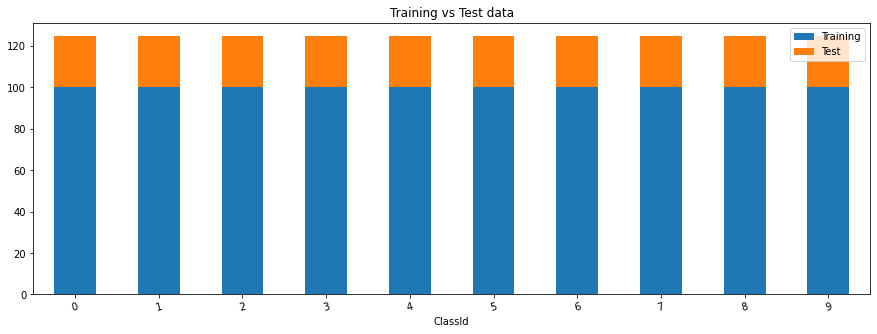

In [18]:
ddata = {"Training":train_df.groupby("ClassId").size(),"Test":test_df.groupby("ClassId").size()}

ddataframe = pd.DataFrame(data=ddata)
ddataframe.plot.bar(stacked= True, rot= 15, title='Training vs Test data',figsize=(15,5))
plt.show(block= True)

4b.Test 20 canned architectures with pre-trained weights with A random 20% sample of the DataFrame:

In [20]:
models = {
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0 ,"input":"MobileNet"},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0, "input":"MobileNet_V2"},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0, "input":"MobileNet_V3"},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0, "input":"MobileNet_V3"}, 
   } 


# note : the image shape "300x300" was chosen after trying several image dimensions, and we chose the one with the highest accuracy.    


for name, model in models.items():
    print("Model: ",name," : ")

    train_generator,test_generator,train_images,val_images,test_images = create_gen(model['input'])
    print('\n')
        
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m 
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=3,verbose=1)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    print('model accurcy: ',models[name]['val_acc'])
    print('\n') 

Model:  MobileNet  : 
Found 800 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


Epoch 1/3
25/25 [==============================] - 6s 187ms/step - loss: 1.8100 - accuracy: 0.4050 - val_loss: 1.2007 - val_accuracy: 0.7200
Epoch 2/3
25/25 [==============================] - 3s 137ms/step - loss: 0.9526 - accuracy: 0.8163 - val_loss: 0.7598 - val_accuracy: 0.8600
Epoch 3/3
25/25 [==============================] - 3s 136ms/step - loss: 0.6394 - accuracy: 0.8938 - val_loss: 0.5721 - val_accuracy: 0.8950


MobileNet            trained in 15.05 sec
model accurcy:  [0.72, 0.86, 0.895]


Model:  MobileNetV2  : 
Found 800 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


Epoch 1/3
25/25 [==============================] - 7s 173ms/step - loss: 1.9587 - accuracy: 0.3512 - val_loss: 1.4002 - val_accuracy: 0.6850
Epoch 2/3
25/25 [==============================] - 3s 138ms/step - loss: 1.1378 - accuracy: 0.7650 - val_loss: 0.9278 - val_accuracy: 0.8350
Epoch 3/3
25/25 [==============================] - 3s 136ms/step - loss: 0.7829 - accuracy: 0.8775 - val_loss: 0.6939 - val_accuracy: 0.8800


MobileNetV2          trained in 13.75 sec
model accurcy:  [0.685, 0.835, 0.88]


Model:  MobileNetV3Large  : 
Found 800 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


Epoch 1/3
25/25 [==============================] - 10s 174ms/step - loss: 1.9996 - accuracy: 0.3487 - val_loss: 1.4365 - val_accuracy: 0.7100
Epoch 2/3
25/25 [==============================] - 3s 131ms/step - loss: 1.2426 - accuracy: 0.7150 - val_loss: 1.0158 - val_accuracy: 0.7600
Epoch 3/3
25/25 [==============================] - 3s 130ms/step - loss: 0.9084 - accuracy: 0.8062 - val_loss: 0.7862 - val_accuracy: 0.8700


MobileNetV3Large     trained in 16.83 sec
model accurcy:  [0.71, 0.76, 0.87]


Model:  MobileNetV3Small  : 
Found 800 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


Epoch 1/3
25/25 [==============================] - 7s 154ms/step - loss: 2.1328 - accuracy: 0.2562 - val_loss: 1.8271 - val_accuracy: 0.4600
Epoch 2/3
25/25 [==============================] - 3s 117ms/step - loss: 1.6054 - accuracy: 0.5763 - val_loss: 1.4545 - val_accuracy: 0.6200
Epoch 3/3
25/25 [==============================] - 3s 117ms/step - loss: 1.2915 - accuracy: 0.7075 - val_loss: 1.1965 - val_accuracy: 0.7700
MobileNetV3Small     trained in 14.92 sec
model accurcy:  [0.46, 0.62, 0.77]




In [21]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_acc','Training time (sec)'])
df_results.sort_values(by='val_acc', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_acc,Training time (sec)
0,MobileNet,0.895,15.05
1,MobileNetV2,0.880,13.75
2,MobileNetV3Large,0.870,16.83
3,MobileNetV3Small,0.770,14.92


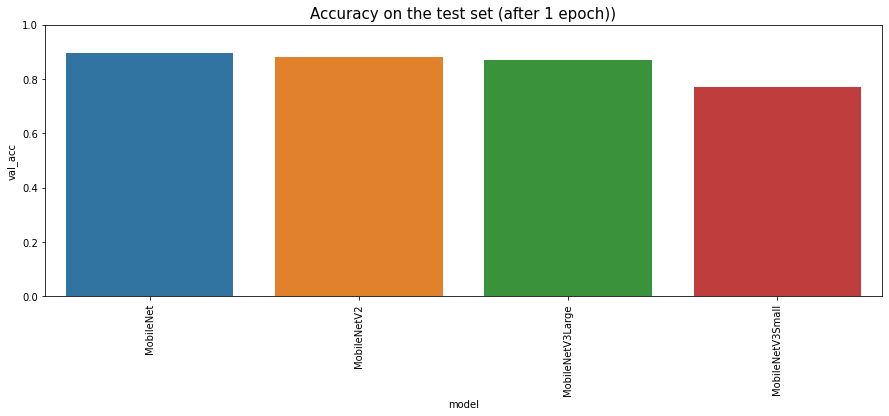

In [22]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_acc', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

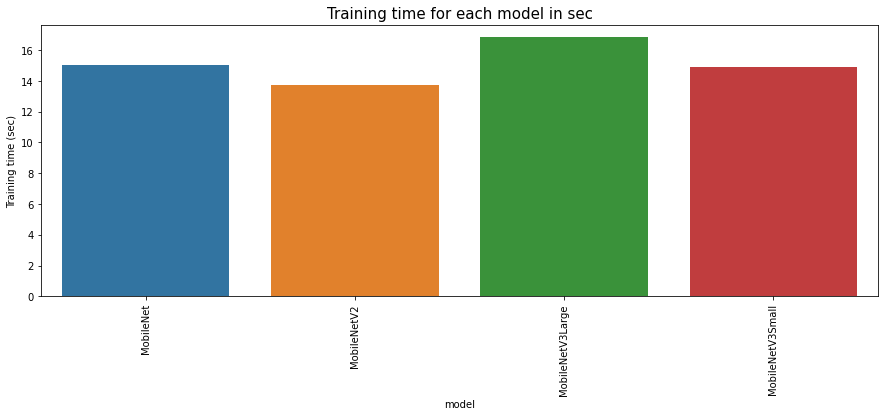

In [23]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

**5. Train the CNN Mobilenet model:**  

5a. Preparing Data :

In [24]:
#SplitData(0.1,0.2) ->split the whole dataset split it into 90% training and 10% testing 
train_df, test_df = SplitData(0.2,1) 
print('Training {} \t # {} per class'.format(train_df.shape[0], train_df.shape[0] //32))
print('Test     {} \t # {} per class'.format(test_df.shape[0], test_df.shape[0] //32))
print('---------------')
print('Sum      {}'.format(train_df.shape[0] + test_df.shape[0]))

666 Samples per Class
Training 5320 	 # 166 per class
Test     1340 	 # 41 per class
---------------
Sum      6660


In [25]:
train_generator,test_generator,train_images,val_images,test_images=create_gen('MobileNet')

Found 4256 validated image filenames belonging to 10 classes.
Found 1064 validated image filenames belonging to 10 classes.
Found 1340 validated image filenames belonging to 10 classes.


In [28]:
model = get_model(tf.keras.applications.MobileNet)
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 9, 9, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_14  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 10)                10250     
                                                                 
Total params: 3,239,114
Trainable params: 10,250
Non-trainable params: 3,228,864
_________________________________________________________________


In [29]:
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=3,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True),  
                         ModelCheckpoint(filepath='number_model.h5', monitor='val_loss', save_best_only= True),                       
                        ])

Epoch 1/3
133/133 [==============================] - 20s 137ms/step - loss: 0.8784 - accuracy: 0.7869 - val_loss: 0.3664 - val_accuracy: 0.9352
Epoch 2/3
133/133 [==============================] - 19s 139ms/step - loss: 0.2761 - accuracy: 0.9523 - val_loss: 0.2015 - val_accuracy: 0.9662
Epoch 3/3
133/133 [==============================] - 19s 140ms/step - loss: 0.1718 - accuracy: 0.9718 - val_loss: 0.1416 - val_accuracy: 0.9793


In [30]:
!tflite_convert \
  --keras_model_file=number_model.h5 \
  --output_file=number_model.tflite

2022-11-08 14:19:32.194881: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W1108 14:19:39.689346 140687539582848 save.py:238] Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 27). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tmp/tmpd0soizak/assets
I1108 14:19:41.578849 140687539582848 builder_impl.py:780] Assets written to: /tmp/tmpd0soizak/assets
I1108 14:19:48.368612 140687539582848 lite.py:1126] Using new converter: If you encounter a problem please file a bug. You can opt-out by setting experimental_new_converter=False
2022-11-08 14:19:48.437948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_fo

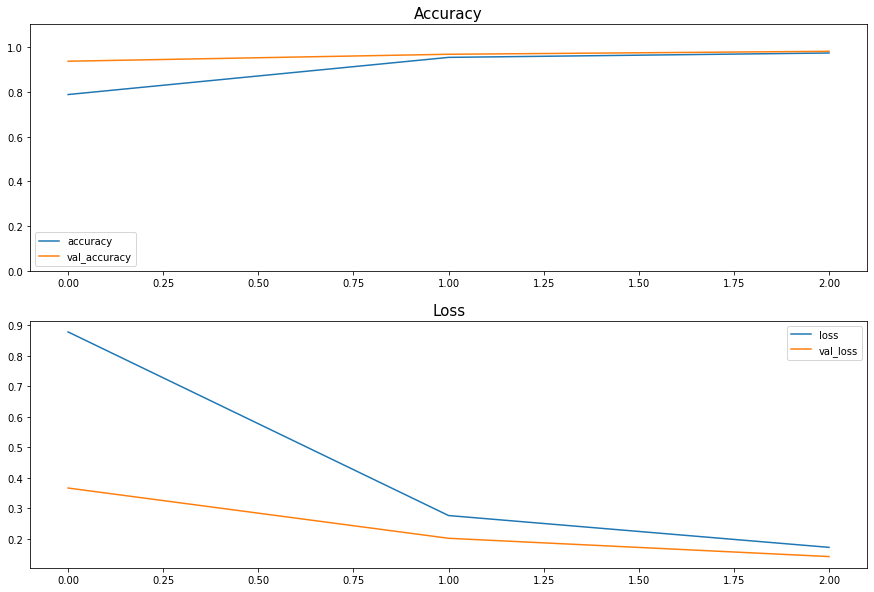

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

**7. Testing the model :**

In [39]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

42/42 [==============================] - 6s 134ms/step


In [50]:
y_test = list(test_df.Class)

**8. Evaluation metrics  :**

8a.Accuracy :

In [51]:
print(f'Model accuracy on the test set is : {accuracy_score(y_test,pred)*100:.2f}%')

Model accuracy on the test set is : 96.64%


8b.Confusion Matrix :

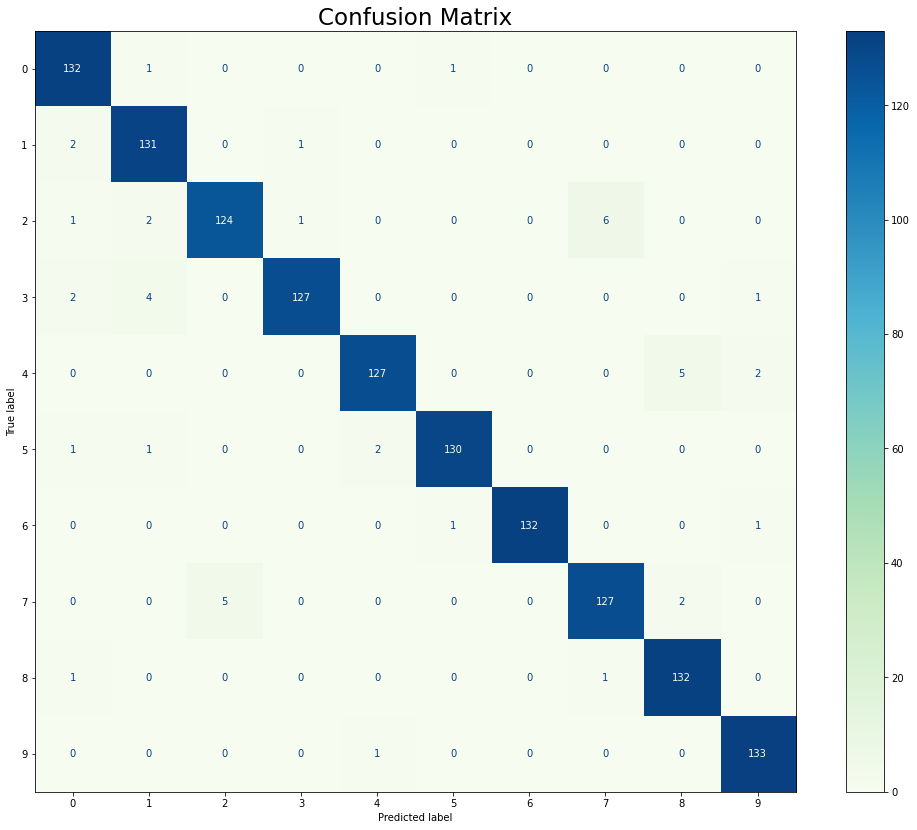

In [52]:
fig, ax = plt.subplots(figsize=(18, 14))
cm = confusion_matrix(y_test, pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=classes.ClassId)
cmp.plot(ax=ax,cmap=plt.cm.GnBu)
plt.title('Confusion Matrix', fontsize = 23)
plt.show();

8c.Classification report :

Model F1 score on the test set is : 96.64%
Model Recall score on the test set is : 96.64%
Model Precision score on the test set is : 96.68%


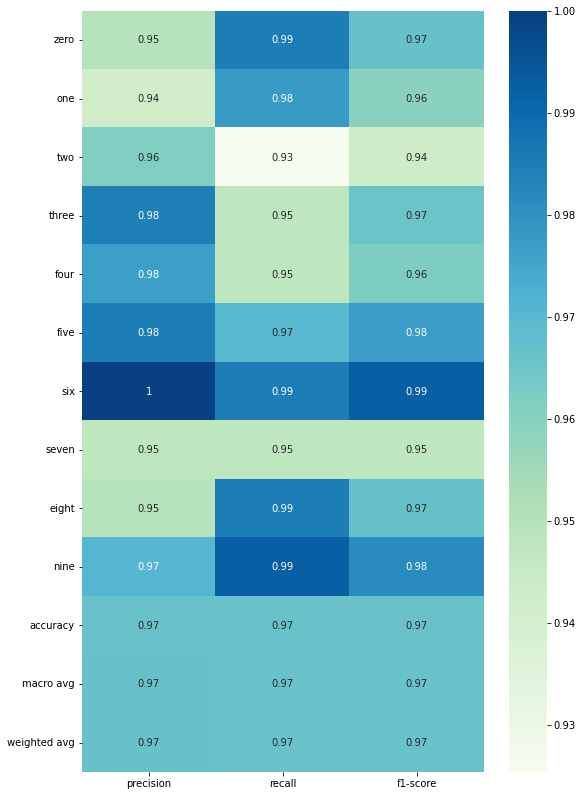

In [53]:
print(f'Model F1 score on the test set is : {(metrics.f1_score(y_test,pred,average="macro"))*100:.2f}%')
print(f'Model Recall score on the test set is : {metrics.recall_score(y_test,pred,average="macro")*100:.2f}%')
print(f'Model Precision score on the test set is : {metrics.precision_score(y_test,pred,average="macro")*100:.2f}%')

clf_report = classification_report(y_test,
                                   pred,
                                   target_names=classes['Class'],
                                   output_dict=True,
                                   digits=3)
fig, ax = plt.subplots(figsize=(9,14))                                      
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap=plt.cm.GnBu)                                  

8e.Area under the ROC :

Model ROC AUC score on the test set is : 98.13%


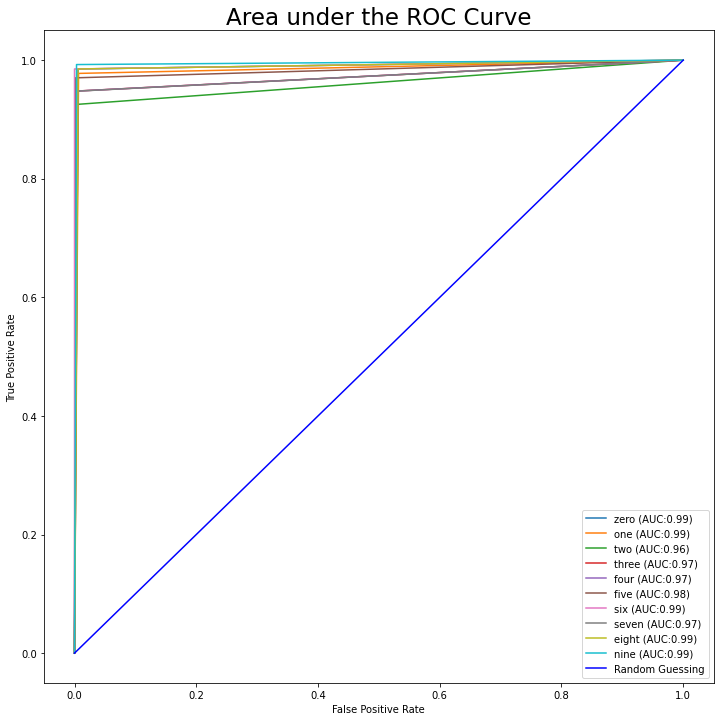

In [54]:
target= classes['Class']
fig, c_ax = plt.subplots(1,1, figsize = (12, 12))

def multiclass_roc_auc_score(test, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(test)
    test = lb.transform(test)
    pred = lb.transform(pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(test[:,idx].astype(int), pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(test, pred, average=average)

print(f'Model ROC AUC score on the test set is : { multiclass_roc_auc_score(y_test, pred)*100:.2f}%')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.title('Area under the ROC Curve', fontsize = 23)
plt.show()

**9. Examples of prediction :**

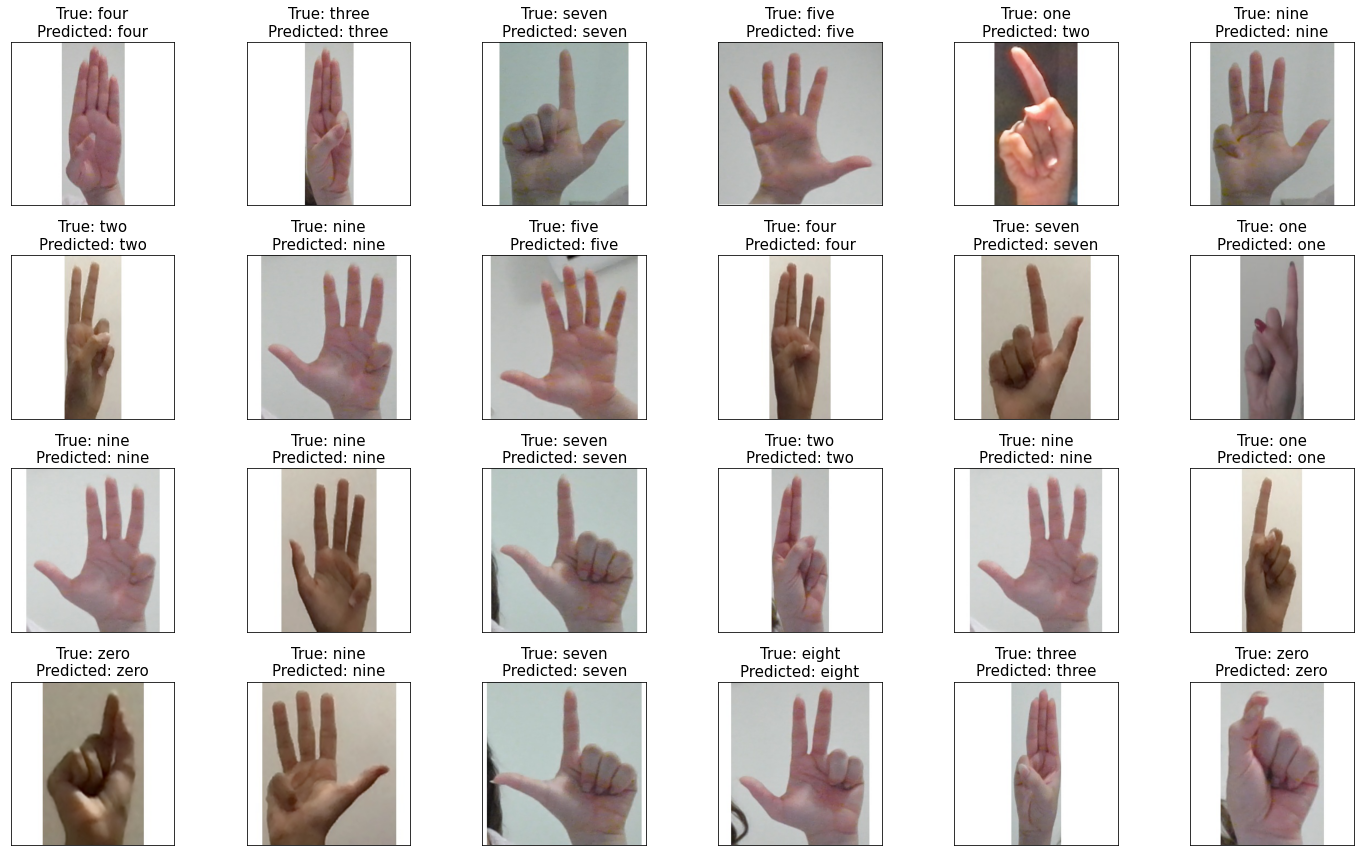

In [55]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.ImagePath.iloc[i]))
    ax.set_title(f"True: {test_df.Class.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()